# 1. NLP 이론문제

## 문제 1
일반 attention에 반해 self attention가 지닌 특징을 서술하시오.

답 : 시퀸스에 있는 모든 단어들이 서로 역할을 바꿔가며 한 단어가 쿼리의 역할을 하면, 나머지 단어들이 키와 벨류 역할을 하면서 모든 단어에 이러한 관계를 만들어낸다

## 문제 2
BERT에 대한 설명이 아닌 것은?

a) 사전 학습 모델

b) 양방향 문맥 이해

c) 트랜스포머의 디코더를 쌓아 올린 구조

d) 이후 RoBERTa와 ALBERT로 발전

답 : c

## 문제 3
BERT와 GPT의 학습 방식 차이를 간단히 설명하세요.

답 : 버트는 트랜스포머의 인코더만을 사용해 학습하지만, gpt는 디코더만 사용해서 학습함

## 문제 4
LLM이 지닌 한계와 Rag의 필요성에 대해 간단히 서술하세요.

답 : llm은 기본적으로 데이터 학습에 매우 많은 자본이 필요하기 때문에, 학습 정보 업데이트 시점이 현재와 다를 수 있고, 아직까지도 일부 할루시네이션이 발생해 거짓 정보를 생성하기도 한다. 하지만 rag는 외부 지식 베이스를 연결해 정보를 찾아서 가져온 뒤, 모델의 생성능력을 결합해 사실관계 오류 가능성과 맥락 이해의 한계를 개선할 수 있다.

# 1. BERT 실습

**BERT (Bidirectional Encoder Representations from Transformers)**
- 문장 분류(스팸 메일 탐지), 질의응답 시스템(챗봇, 검색 엔진), 번역(다국어 지원), 텍스트 요약(뉴스 요약) 등 다양한 NLP 작업에 사용
- 문맥을 양방향으로 이해하여 텍스트의 의미를 정밀하게 파악하며, 사전 학습된 모델을 기반으로 빠르게 응용 가능

### 1. 모델과 tokenizer 초기화
- tokenizer를 통해 문장을 토큰으로 나누고, 이를 정수 인덱스로 변환하여 모델이 이해할 수 있도록 함

In [4]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# BERT 모델과 tokenizer 초기화
tokenizer = BertTokenizer.from_pretrained('klue/bert-base') # base : 모델크기, (uncased : 소문자 학습)
model = BertForMaskedLM.from_pretrained('klue/bert-base') # base : 모델크기, (uncased : 소문자 학습)
# tokenizer : raw text를 개별 토큰으로 분리(Wordpiece). 토크나이저 사전에 따라 고유한 정수 인덱스(고정값)를 매핑함.

# tokenizer를 통해 생성된 정수 인덱스 : 텍스트를 모델이 읽을 수 있도록 숫자화
# Embedding vector : 단어의 의미적, 문맥적 특성을 모델링

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 2. 입력 텍스트 준비 및 토큰화
- [MASK] 토큰을 삽입한 문장을 설정하고, tokenizer.tokenize()로 텍스트 토큰화
- [MASK]를 활용하여 문맥 속에서 특정 단어를 추론하는 상황을 만들고, 이를 모델이 학습한 패턴과 비교하도록 함


In [5]:
# 테스트할 문장
text = "[CLS] 열여덟, 우리는 서로의 이름을 처음 불렀다. 그리고 스물 하나, 우린 [MASK]을 했다.[SEP]"

# 문장을 토큰으로 변환
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(tokenized_text)
print(indexed_tokens)


['[CLS]', '열', '##여', '##덟', ',', '우리', '##는', '서로', '##의', '이름', '##을', '처음', '불렀', '##다', '.', '그리고', '스물', '하나', ',', '우린', '[MASK]', '을', '했', '##다', '.', '[SEP]']
[2, 1432, 2173, 3542, 16, 3616, 2259, 4084, 2079, 3934, 2069, 3790, 6895, 2062, 18, 3673, 10514, 3657, 16, 8983, 4, 1498, 1902, 2062, 18, 3]


### 3. MASK된 위치 확인
- [MASK] 토큰의 위치를 탐지해 해당 위치에서 모델이 단어를 예측하도록 지정합니다.


In [6]:
# 마스킹된 위치 찾기
masked_index = tokenized_text.index("[MASK]") ; print(masked_index)

20


### 4. 정수화된 토큰 인덱스를 tensor로 변환 후 모델 예측 실행
- 모델은 텐서 데이터 구조를 필요로 하므로, 입력값을 변환하여 적합한 형식으로 만듦.
- 역전파를 비활성화하고, 모델이 각 토큰에 대해 가능한 모든 단어 점수 출력

In [7]:
# 토큰화된 텍스트 -> 정수인덱스(ID) -> Pytorch 텐서
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])

# 모델에 토큰 텐서를 전달하고 예측 실행
with torch.no_grad(): # 가중치 업데이트 없으므로 자동미분연산은 끔
    outputs = model(tokens_tensor) # 예측. 모델은 각 토큰위치에 대한 예측 결과를 반환.
    predictions = outputs[0] # logits (각 토큰위치에서 가능한 모든 토큰들의 원시점수)
print(predictions)

tensor([[[ -6.0337,   4.5526,  -5.6312,  ...,  -7.3959,  -7.4220,  -5.8337],
         [ -6.1762,   4.7585,  -7.3973,  ...,  -7.6209, -12.2124,  -6.0998],
         [ -7.4194,   3.9148,  -6.1517,  ...,  -6.8162,  -9.5421,  -3.0473],
         ...,
         [ -7.3761,   8.6972,  -5.4904,  ...,  -8.7202,  -9.1403,  -5.8566],
         [ -5.6347,  10.3884,  -4.3374,  ...,  -8.6900,  -7.4171,  -3.5043],
         [ -5.6652,  10.3407,  -4.4099,  ...,  -8.7521,  -7.4286,  -3.6681]]])


### 5. MASK된 토큰 예측
- [MASK] 위치에서 가장 높은 점수를 받은 토큰의 인덱스를 추출하고, 이를 단어로 변환

In [8]:
# 예측된 토큰 확인
predicted_index = torch.argmax(predictions[0, masked_index]).item() # masked_index에 들어갈 것으로 가장 확률이 높은 인덱스
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

# 예측된 토큰으로 마스크 채우기
tokenized_text[masked_index] = predicted_token
# 토큰화된 텍스트를 다시 문자열로 변환
filled_text = tokenizer.convert_tokens_to_string(tokenized_text[1:-1])

print("Original:", text)
print("Masked:", tokenized_text)
print("Predicted token:", predicted_token) ; print()

print("Filled sentence:", filled_text)

Original: [CLS] 열여덟, 우리는 서로의 이름을 처음 불렀다. 그리고 스물 하나, 우린 [MASK]을 했다.[SEP]
Masked: ['[CLS]', '열', '##여', '##덟', ',', '우리', '##는', '서로', '##의', '이름', '##을', '처음', '불렀', '##다', '.', '그리고', '스물', '하나', ',', '우린', '사랑', '을', '했', '##다', '.', '[SEP]']
Predicted token: 사랑

Filled sentence: 열여덟 , 우리는 서로의 이름을 처음 불렀다 . 그리고 스물 하나 , 우린 사랑 을 했다 .



### 6. MASK된 문장 복원
- 예측된 토큰으로 [MASK]를 대체하여 완성된 문장 생성

In [9]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# BERT 모델과 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
model = BertForMaskedLM.from_pretrained('klue/bert-base')

def fill_mask(input_text):
    # 텍스트를 토큰으로 변환
    tokenized_text = tokenizer.tokenize(input_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # 마스킹된 위치 찾기
    masked_index = tokenized_text.index("[MASK]")

    # 토큰화된 텍스트 -> 정수인덱스(ID) -> Pytorch 텐서
    tokens_tensor = torch.tensor([indexed_tokens])

    # 모델에 토큰 텐서를 전달하고 예측 수행
    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    # 예측된 토큰 확인
    predicted_index = torch.argmax(predictions[0, masked_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

    # 마스크를 채운 문장 반환
    tokenized_text[masked_index] = predicted_token
    return tokenizer.convert_tokens_to_string(tokenized_text[1:-1])

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


예시 문장 만들어서 MLM을 사용해 보세요!

In [16]:
# 예시 1: "[CLS] 열여덟, 우리는 서로의 이름을 처음 불렀다. 그리고 스물 하나, 우린 [MASK]을 했다.[SEP]"
# 예시 2: "[CLS] 연동운은 INSGIHT 학회를 정말 사랑한다. 그는 INSIGHT 학회를 위해 [MASK]를 했다.[SEP]"
# 이 예시를 참고해서 [CLS](맨 앞), [MASK](채울 부분), [SEP](맨 뒤)를 추가해서 여러분만의 예시 문장 만들어주세요
input_text = "[CLS] AI가 분석한 결과, 김민지, 김윤서, 김일호, 김재성, 김찬우, 김현서, 노승혁, 류한결, 문건우, 문선아, 엄태림, 윤해민, 이종현, 이지현, 황종빈 이렇게 총 15 명의 INSGIHT의 13기 학회원 중 차기 회장은 [MASK]이다.[SEP]" # 자유롭게 예시 문장 만들어보세요!
filled_text = fill_mask(input_text)
print("Filled sentence:", filled_text)

Filled sentence: AI가 분석한 결과 , 김민지 , 김윤서 , 김일호 , 김재성 , 김찬우 , 김현서 , 노승혁 , 류한결 , 문건우 , 문선아 , 엄태림 , 윤해민 , 이종현 , 이지현 , 황종빈 이렇게 총 15 명의 INSGIHT의 13기 학회원 중 차기 회장은 문재인 이다 .


??? 뭔가요 이거

In [18]:
input_text = "[CLS] AI가 분석한 결과, 민지, 윤서, 일호, 재성, 찬우, 현서, 승혁, 한결, 건우, 선아, 태림, 해민, 종현, 지현, 종빈 이렇게 총 15 명의 INSGIHT의 13기 학회원 중 차기 회장에 가장 적합한 사람은 [MASK]이다.[SEP]" # 자유롭게 예시 문장 만들어보세요!
filled_text = fill_mask(input_text)
print("Filled sentence:", filled_text)

Filled sentence: AI가 분석한 결과 , 민지 , 윤서 , 일호 , 재성 , 찬우 , 현서 , 승혁 , 한결 , 건우 , 선아 , 태림 , 해민 , 종현 , 지현 , 종빈 이렇게 총 15 명의 INSGIHT의 13기 학회원 중 차기 회장에 가장 적합한 사람은 지현 이다 .


### 7. 한국어 금융 뉴스 긍정, 부정 분류

In [95]:
!pip install transformers
!pip install datasets

finance_data.csv를 다운로드 합니다

In [96]:
!wget https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv

--2025-05-27 06:32:34--  https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1319001 (1.3M) [text/plain]
Saving to: ‘finance_data.csv.2’

finance_data.csv.2  100%[===================>]   1.26M  --.-KB/s    in 0.007s  

2025-05-27 06:32:34 (193 MB/s) - ‘finance_data.csv.2’ saved [1319001/1319001]



In [97]:
import pandas as pd
df = pd.read_csv('finance_data.csv')

In [98]:
df.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [99]:
print('샘플의 개수 :', len(df))

샘플의 개수 : 4846


neutral, positive. negative를 숫자로 바꿔줍니다. <br>
neutral:0, positive:1, negative:2로 바꿀게요

In [100]:
df['labels'] = df['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
df.head()

<ipython-input-100-910beaa298a3>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['labels'] = df['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])


,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


위의 dataframe을 dataset 객체로 변환해줍니다

In [101]:
from datasets import Dataset

all_data = Dataset.from_pandas(df)

In [102]:
all_data

Dataset({
    features: ['labels', 'sentence', 'kor_sentence'],
    num_rows: 4846
})

all_data를 train과 test로 나눠줍니다<br>
train : test = 4 : 1로 나눠줍니다

In [103]:
cs = all_data.train_test_split(test_size=0.2)

train_cs = cs['train']
test_cs = cs['test']

In [104]:
train_cs

Dataset({
    features: ['labels', 'sentence', 'kor_sentence'],
    num_rows: 3876
})

In [105]:
test_cs

Dataset({
    features: ['labels', 'sentence', 'kor_sentence'],
    num_rows: 970
})

In [106]:
print("-----train_cs-----")
print(train_cs)
print("-----test_cs-----")
print(test_cs)

-----train_cs-----
Dataset({
    features: ['labels', 'sentence', 'kor_sentence'],
    num_rows: 3876
})
-----test_cs-----
Dataset({
    features: ['labels', 'sentence', 'kor_sentence'],
    num_rows: 970
})


특정 샘플과, 샘플에 해당하는 레이블을 출력합니다.<br>
레이블은 0: neutral, 1: positive, 2: negative였죠

In [107]:
print('샘플:', train_cs['kor_sentence'][0])
print('샘플의 레이블:', train_cs['labels'][0])

샘플: 엘리사는 "3세대 모바일 기술을 채택한 고객들 덕분에 2007년 한 해 동안 모바일 가입이 7% 증가했다"고 말했다.
샘플의 레이블: 1


In [108]:
import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm import tqdm

import csv
import os

import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss

훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 `[CLS] 문장 [SEP]` 구조를 만듭니다.


In [109]:
train_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', train_cs['kor_sentence']))
test_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', test_cs['kor_sentence']))

train, validation, test에 대해 labels 정보만 따로 저장합니다

In [110]:
train_labels = train_cs['labels']
test_labels = test_cs['labels']

test_sentences와 test_labels를 확인합니다

In [111]:
test_sentences[:5]

['[CLS] 거래는 내년 봄에 완료될 것으로 예상된다. [SEP]',
 '[CLS] 이들 중 73명은 원더웨어 시스템 플랫폼과 같은 최신 ArchistrA 기술을 기반으로 한 제품에 대한 보다 광범위한 교육도 받고 있다. [SEP]',
 '[CLS] 유타의 수도는 스키 장비 회사인 아머 스포츠사의 다음 미국 본사가 되기를 원했다. [SEP]',
 '[CLS] 회사 측은 휴대폰 충전기 시장의 치열한 경쟁에 부응하기 위해 영업 효율화 조사에 착수했다고 밝혔다. [SEP]',
 '[CLS] 에콰도르 이노바르-UIO의 엠프레사 데 데사롤로 우르바노 데 키토는 포이리에게 새로운 도시형 대중 교통 시스템을 위한 타당성 조사를 준비하라고 의뢰했다. [SEP]']

In [112]:
test_labels[:5]

[0, 0, 0, 1, 0]

tokenizer와 model을 불러옵니다.<br>
tokenizer로는 BertTokenizer를 사용하고, model은 분류모델인 BertForSequenceClassification을 사용합니다<br>
우리는 neutral, negative, positive중에 하나를 예측해야 하므로, num_labels에 3을 넣어서 model에 num_labels를 넘겨줍니다

In [113]:
# 한국어 BERT 중 하나인 'klue/bert-base'를 사용.
tokenizer = BertTokenizer.from_pretrained('klue/bert-base') # 사전학습 된 상태로 불러옵니다

num_labels = 3

model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=num_labels) # 사전학습 된 상태로 불러옵니다

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
# 원래 BERT는 max_length가 512지만, 128로 축소해서 학습하면 더 빠른 시간에 학습이 가능합니다.
# MAX_LEN을 128로 하고, 성능이 좋지 않으면 MAX_LEN을 256 -> 384 -> 512로 늘려가며 비교하는 것도 방법입니다
MAX_LEN = 128

# 실습때 했던 encode_korquad_examples() 함수 기억하시나요? 그 함수와 유사하게 작성되었습니다.
def encode_classification_data(sentences, labels):
    encodings = tokenizer(
        sentences,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_mask, labels)
    return dataset


train, validation, test 데이터셋을 생성합니다

In [115]:
train_dataset = encode_classification_data(train_sentences, train_labels)
test_dataset = encode_classification_data(test_sentences, test_labels)

In [116]:
print('훈련 데이터의 크기:', len(train_dataset))
print('테스트 데이터의 크기:', len(test_dataset))

훈련 데이터의 크기: 3876
테스트 데이터의 크기: 970


DataLoader를 생성합니다

In [117]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),  # 테스트도 일반적으로 Sequential을 씀
    batch_size=batch_size
)


In [118]:
# 옵티마이저 지정
# AdamW 사용합니다
# AdamW에 모델의 파라미터 정보를 넘겨줍니다.
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)

모델을 학습합니다

In [119]:
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu 사용 가능하면 gpu(cuda)로, 그렇지 않으면 cpu로
model.to(device)

for epoch_i in range(epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    total_loss = 0

    model.train() # 모델을 학습 모드로 설정합니다

    loop = tqdm(train_dataloader, desc=f'Epoch {epoch_i + 1}', leave=False)

    for step, batch in enumerate(loop):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        optimizer.zero_grad() # 가중치 0으로 초기화

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward() # 역전파
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step() # 파라미터 업데이트

        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)

    print(f"\n  Average training loss: {avg_train_loss:.4f}")


======== Epoch 1 / 2 ========



  Average training loss: 0.4948

======== Epoch 2 / 2 ========



  Average training loss: 0.2729


학습된 모델의 가중치를 저장합니다

In [120]:
torch.save(model.state_dict(), "BERT_news.pt")

모델의 가중치를 다시 불러옵니다<br>
- 지금처럼 학습과 테스트를 한 번에 이어서 할 때는 모델 가중치를 다시 불러올 필요가 없습니다.
- 그러나 내가 이전에 학습한 모델을 사용해서 예측을 수행하고 싶을 때는 다음과 같이 이전에 학습된 가중치를 불러와야 합니다

In [121]:
num_labels = 3

model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
model.load_state_dict(torch.load("BERT_news.pt"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

평가하기 위한 함수를 정의합니다

In [122]:
def compute_metrics(preds, labels):
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'f1_micro': f1_score(labels, preds, average='micro', zero_division=0),
        'f1_weighted': f1_score(labels, preds, average='weighted', zero_division=0)
    }

테스트 데이터에 대해 평가를 수행합니다

In [123]:
from tqdm import tqdm

model.eval()
model.to(device)
accum_logits, accum_label_ids = [], []

for batch in tqdm(test_dataloader, desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            token_type_ids=None
        )

    logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 예측 결과 저장
    accum_logits.extend(np.argmax(logits, axis=1))
    accum_label_ids.extend(label_ids)

# NumPy 배열로 변환
accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)

# 메트릭 계산
results = compute_metrics(accum_logits, accum_label_ids)

# 출력
print("\n[✔️ Test Evaluation Result]")
print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))

Testing: 100%|██████████| 61/61 [00:07<00:00,  8.38it/s]


[✔️ Test Evaluation Result]
Accuracy: 0.8536
F1 (Macro) Score: 0.8360
F1 (Micro) Score: 0.8536
F1 (Weighted) Score: 0.8528


HuggingFace transformers 라이브러리의 pipeline API를 활용하면 텍스트 분류 모델을 추론하기 위한 설정을 편리하게 할 수 있습니다

In [124]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = pipeline("text-classification", # 수행할 작업: 텍스트 분류
                model=model.to(device), # 사용할 모델
                tokenizer=tokenizer, # 모델에 맞는 토크나이저
                max_length=512, # 입력 문장 최대 길이
                return_all_scores=True, # 모든 클래스의 확률 반환
                function_to_apply='softmax' # softmax 사용
)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [125]:
result = pipe('SK하이닉스가 매출이 급성장하였다') # 이 문장에 대해 label 점수를 보면
print(result)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[[{'label': 'LABEL_0', 'score': 0.12372135370969772}, {'label': 'LABEL_1', 'score': 0.863305926322937}, {'label': 'LABEL_2', 'score': 0.012972715310752392}]]


return_all_scores = True로 했기 때문에 LABEL_0, LABEL_1, LABEL_2의 모든 score가 다 출력됩니다

LABEL_0, LABEL_1, LABEL_2 대신에 중립, 긍정, 부정으로 출력하도록 label_dict를 설정합니다

In [126]:
label_dict = {'LABEL_0' : '중립', 'LABEL_1' : '긍정', 'LABEL_2' : '부정'}

label_dict에서 LABEL_0, LABEL_1, LABEL_2를 중립, 긍정, 부정으로 바꿔서 출력하는 함수를 정의합니다

In [127]:
def prediction(text):
  result = pipe(text)

  return [label_dict[result[0]['label']]]

In [128]:
# 이전의 pileline 코드에서 return_all_scores를 제거합니다. return_all_scores는 default가 False입니다
pipe = pipeline("text-classification", model=model.to(device), tokenizer=tokenizer, max_length=512,function_to_apply='softmax')

Device set to use cuda:0


In [129]:
result = pipe('SK하이닉스가 매출이 급성장하였다')
print(result)

[{'label': 'LABEL_1', 'score': 0.863305926322937}]


return_all_scores를 False로 했으므로 가장 높은 score의 LABEL만 출력됩니다

prediction 함수를 사용하여 다양한 금융 텍스트의 긍정/부정/중립을 분석해보면

In [130]:
prediction('SK하이닉스가 매출이 급성장하였다')

['긍정']

In [131]:
prediction('ChatGPT의 등장으로 인공지능 스타트업들은 비상이다')

['중립']

In [132]:
prediction('인공지능 기술의 발전으로 누군가는 기회를 얻을 것이고, 누군가는 얻지 못할 것이다')

['중립']

In [133]:
prediction('삼성전자의 주가가 상승곡선을 그리고 있다')

['긍정']

# 2. Text Generation : GPT

In [2]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

# 모델과 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')

# 시작 텍스트 설정
# 예시 text = '인사이트 13기 회장, 부회장은 과연 누가 될까? 너무 기대된다'
# 예시 텍스트 말고 다른 text 직접 입력해보세요! 기발한 아이디어 기다립니다ㅎㅎ
text = '금융 경제분야, 수화 번역, 추천 시스템 분석, 패션 플랫폼 리뷰 nlp, 날씨 예측 공모전, 방송통신위원회 데이터 분석 공모전이라는 다양한 주제로 진행되는 이번 2차 인사이콘에서 어떤 팀이 우승할까?'
input_ids = tokenizer.encode(text, return_tensors='pt')

# 텍스트 생성
gen_ids = model.generate(input_ids,
                         max_length=128,
                         repetition_penalty=2.0,
                         pad_token_id=tokenizer.pad_token_id,
                         early_stopping=True,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
                         use_cache=True)
generated = tokenizer.decode(gen_ids[0])

print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


금융 경제분야, 수화 번역, 추천 시스템 분석, 패션 플랫폼 리뷰 nlp, 날씨 예측 공모전, 방송통신위원회 데이터 분석 공모전이라는 다양한 주제로 진행되는 이번 2차 인사이콘에서 어떤 팀이 우승할까?라는 질문에 대해 “1차 예선에서 탈락한 팀들이 다시 도전해보고 싶다”며 “이번에도 좋은 결과가 있을 것으로 기대한다”고 말했다.
이날 1차 합격자 발표는 오는 24일 오후 6시 30분부터 진행되며, 최종 결과는 26일 오전 10시에 발표된다.</d> 한국토지주택공사(LH)는 지난달 말 기준 전국 미분양 주택은 총 1만2천911가구로 전월(1


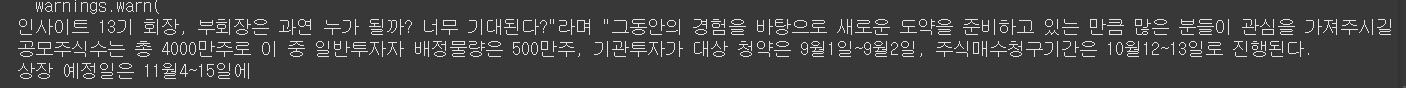

ㅋㅋㅋㅋ 회장, 부회장의 단어를 보고 인사이트를 기업으로 인식한 거 같아요

과제 끝!!

# 3. Langchain ~ Rag (참고)

### Langchain
- LLM을 사용한 어플리케이션 개발 단순화를 위한 프레임워크
- python과 JavaScript 라이브러리 제공
- 요약, 번역, 챗봇, QnA, 데이터 증강(Augmentation) 등의 서비스 구현 가능

### RAG
- LLM 모델의 단점 중 사실 관계 오류 가능성과 맥락 이해의 한계를 개선하는데 초점을 맞춘 방법
- 외부 지식 베이스를 연결해 모델의 생성 능력과 사실 관계 파악 능력 향상
- 할루시네이션 감소와 최신 정보 반영에 유리

아래 코드 실행하려면 OPEN AI의 langchain API Key가 필요한데, 현재는 유료라서... 그냥 실행하지 말고 보기만 해주세요

In [135]:
!pip install unstructured
!pip install sentence-transformers
!pip install chromadb
!pip install openai
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 57.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 11.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=b499e4861f236974b4829ff7adabb838e92e2f1f3ff7e640c244c7fbfbb692c6
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4b

## 1. 데이터 가져오기
- 분석할 문서를 불러와 데이터 파이프라인의 입력으로 사용
- 자연어 처리를 수행하기 위해 원천 데이터를 준비하는 단계


In [136]:
from langchain.document_loaders import TextLoader
documents = TextLoader("AI.txt").load()

ModuleNotFoundError: Module langchain_community.document_loaders not found. Please install langchain-community to access this module. You can install it using `pip install -U langchain-community`

## 2. 텍스트 분할
- 긴 문서를 일정 크기의 청크로 나눠 처리 가능하도록 만듦
- 검색 효율성과 모델의 입력 제약을 고려한 전처리 작업


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 문서를 청크로 분할
def split_docs(documents,chunk_size=1000,chunk_overlap=20):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  docs = text_splitter.split_documents(documents)
  return docs

# docs 변수에 분할 문서를 저장
docs = split_docs(documents)

## 3. 임베딩 변환
- 텍스트 데이터를 벡터 공간으로 매핑하여 기계 학습 모델이 이해할 수 있는 수치 데이터로 변환
- 텍스트의 의미적 유사성을 계산하고 처리를 자동화하기 위한 단계


In [ ]:
from langchain.embeddings import SentenceTransformerEmbeddings
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

## 4. 벡터 저장
- 변환된 벡터 데이터를 데이터베이스에 저장하여 고속 검색과 활용 지원
- 효율적인 질의 응답 및 문서 검색 시스템 구현을 위한 핵심 단계

In [ ]:
# Chromdb에 벡터 저장
from langchain.vectorstores import Chroma
db = Chroma.from_documents(docs, embeddings)

## 5. 질문 응답
- 입력된 질문과 관련된 문서를 검색한 뒤 GPT 모델로 답변 생성
- 사용자 질문에 적합한 답변을 제공하기 위해 유사 문서 검색과 자연어 처리를 결합한 핵심 과정

In [ ]:
import os #운영체제(os) 모듈을 가져올 때 사용되는 라이브러리
os.environ["OPENAI_API_KEY"] = "sk-" #openai 키 입력 -> 현재 유료로 사용 가능,,,ㅠㅠ

from langchain.chat_models import ChatOpenAI
model_name = "gpt-3.5-turbo"  #GPT-3.5 turbo 모델 사용
llm = ChatOpenAI(model_name=model_name)

# Q&A 체인을 사용하여 쿼리에 대한 답변 얻기
from langchain.chains.question_answering import load_qa_chain
chain = load_qa_chain(llm, chain_type="stuff",verbose=True)

# 쿼리를 작성하고 유사성 검색을 수행하여 답변을 생성,따라서 txt에 있는 내용을 질의해야 합니다
query = "AI란?"
matching_docs = db.similarity_search(query)
answer =  chain.run(input_documents=matching_docs, question=query)
answer